# Background

A while ago I had a problem of calculating element surface areas from finite element model for a post process analysis. Let's illustrate the problem:

![ball_picture](ball_and_ele_2.png)

As you can see there is a ball, which is constructed from a finite number of elements (let's make an assumption, that these elements are brick elements, just like the one that the arrow is pointing at). Each element has 20 nodes (the yellow points) and the objective was to calculate just the red surface area of the element. The information we have are the coordinates of the nodes and the element type. My first approach was to google for solutions. After a while I found analytical algorithms for calculating surface areas in a plane (triangles, boxes, using curve, ...). Only problem with these algorithms were that they defined in 2D but the problem we have here is to calculate surface area in 3D space. Since I didn't find any easy solutions (I don't say there isn't one, I just didn't have the patience to search deeper), so here's an solution I tinkered using [Julia](http://julialang.org/) programming language.

# Theory

Since the problem was related to finite element model, I think we'll make a short introduction to the method:


> The finite element method (FEM) is a numerical technique for finding approximate solutions to boundary value problems for partial differential equations. It is also referred to as finite element analysis (FEA). FEM subdivides a large problem into smaller, simpler, parts, called finite elements. The simple equations that model these finite elements are then assembled into a larger system of equations that models the entire problem. FEM then uses variational methods from the calculus of variations to approximate a solution by minimizing an associated error function. (ref [Wikipedia](https://en.wikipedia.org/wiki/Finite_element_method))

In finite element method field variables are integrated over volume or area, depending on the simulation dimension. But calculating variables (e.g. stiffness tensor) can prove to be difficult to calculate, since:

* The construction of shape functions that satisfy consistency requirements for higher order elements with curved boundaries becomes increasingly complicated

* Integrals that appear in the expressions of the element stiffness matrix and consistent nodal force vector can no longer be evaluated in simple closed form.

Luckily these obsticles were overcome through the concepts of isoparametric mapping and numerical quadrature. Combining these ideas transformed the field of finite element methods during the 1960's. Without any further introduction, let's dig in. (ref. [colorado university](http://www.colorado.edu/engineering/CAS/courses.d/IFEM.d/IFEM.Ch16.d/IFEM.Ch16.pdf))


## Isoparametric mapping

As you can see in the picture, the goal is to map element from local coordiantes system to global coordinate system. This can be achived with the use of shape functions.

![a picture of nature](changing_coordiante_system.png)

### Shape functions

Shape functions or basis fuctions are used to obtain an approach solution to the exact solution (ref. [Kratos](http://kratos-wiki.cimne.upc.edu/index.php/Shape_Functions)). Shape functions can represent both the element geometry and the problem unknowns, hence the name isoparametric element ("iso" means equal). In the Finite Element Method is used a lineal combination to interpolate the solution:

<p style="text-align: center;">
$x = \sum_{i=1} N_i x_i$
</p>

in which $N_i$ are the shape functions (functions of $\eta$ and $\xi$) and $x_i$ are coordinates of given node. The number of shape functions used for given element corresponds to the number of nodes in element. For example, linear 1D bar element can be defined with two shape functions:

<p style="text-align: center;">
$N(\xi) = \begin{bmatrix}
       \frac{1-\xi}{2}\\[0.3em]
       \frac{1+\xi}{2}
     \end{bmatrix}$
</p>
<img src="bar_element.png" width="500">

Let's plot this shape function within element's area

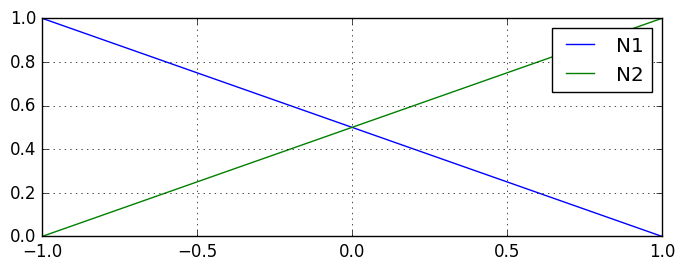

In [1]:
using PyPlot
subplot(2,1,2)
N_lin_bar(ξ) = [(1-ξ)/2., (1+ξ)/2.]
x_axis = linspace(-1, 1, 10)
n_vals = map(x-> N_lin_bar(x), x_axis)
N1 = map(x-> x[1], n_vals)
N2 = map(x-> x[2], n_vals)

plot(x_axis, N1, label="N1")
plot(x_axis, N2, label="N2")
legend()
grid()

As you can see $N_1$, which is the first element in $N$, corresponds to the node #1, since it gains the value of 1 in that node. $N_2$, which is the second element in $N$, corresponds to the node #2. Now that the shape functions work, let's try to interpolate x coordinate within the element.

In [2]:
# example coordinates
x_example = [3, 5]
println("Coordinate in first node:            $(dot(N_lin_bar(-1), x_example))")
println("Coordinate in the middle of element: $(dot(N_lin_bar(0), x_example))")
println("Coordinate in second node:           $(dot(N_lin_bar(1), x_example))")

Coordinate in first node:            3.0
Coordinate in the middle of element: 4.0
Coordinate in second node:           5.0


Ok, cool thing. There are many documentations/sites, where to acquire shape functions for different shapes, but I'll be using from [code aster](http://www.code-aster.org/V2/doc/v11/en/man_r/r3/r3.01.01.pdf) documentation. Now let's try the same with a square with four (4) nodes:

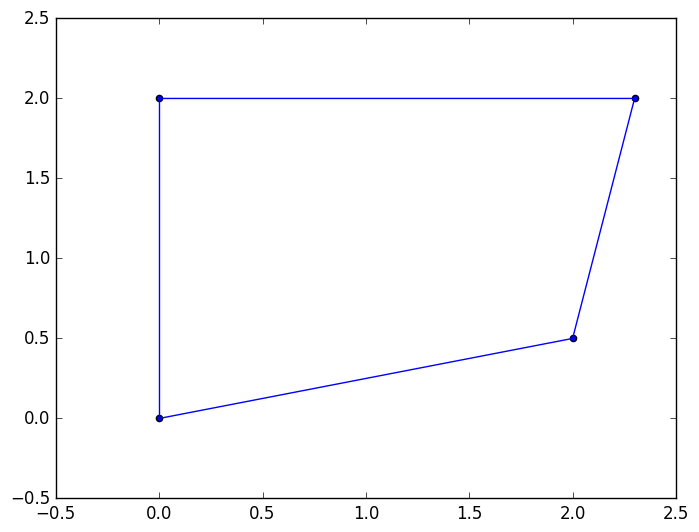

Coordinates in first node:            x = 0.0,   y = 0.0
Coordinates in the middle of element: x = 1.075, y = 1.125
Coordinates in second node:           x = 2.0,   y = 0.5
Coordinates in third node:            x = 2.3,   y = 2.0


In [3]:
# example coordinates
x_coords = [0, 2, 2.3, 0]
y_coords = [0, 0.5, 2, 2]

# shape functions
N_quad_4(η, ξ) = [  0.25 * (1 - ξ) * (1 - η),
                    0.25 * (1 - ξ) * (1 + η),
                    0.25 * (1 + ξ) * (1 + η),
                    0.25 * (1 + ξ) * (1 - η) ]

# calculate shape functions values in various locations in local coordinates
f_n_1 = N_quad_4(-1, -1)
f_n_2 = N_quad_4(0 ,0)
f_n_3 = N_quad_4(1, -1)
f_n_4 = N_quad_4(1, 1)

# Plotting twice just to get a closed 
plot(x_coords, y_coords)
plot([x_coords[end], x_coords[1]], [y_coords[end], y_coords[1]], "b")
scatter(x_coords, y_coords);

println("Coordinates in first node:            x = $(dot(f_n_1, x_coords)),   y = $(dot(f_n_1, y_coords))")
println("Coordinates in the middle of element: x = $(dot(f_n_2, x_coords)), y = $( dot(f_n_2, y_coords))")
println("Coordinates in second node:           x = $(dot(f_n_3, x_coords)),   y = $(dot(f_n_3, y_coords))")
println("Coordinates in third node:            x = $(dot(f_n_4, x_coords)),   y = $(dot(f_n_4, y_coords))")

## Gaussian quadrature

Now that we can get the coordinates within element, we can focus on integrating the area. Let's say we want to integrate some field variable over surface:

$F = \int_{\Omega_A} f(x,y)\hspace{2mm} dA$

Using integration rules we can transform area integration:

$\int_{\Omega_A} f(x,y)\hspace{2mm} dA = \int_{-1}^1\int_{-1}^1 f(\eta, \xi) \det J\hspace{2mm}d\eta d\xi$

in which $J$ is jacobian (as seen [here](http://download.springer.com/static/pdf/272/bbm%253A978-3-540-32609-0%252F1.pdf?originUrl=http%3A%2F%2Flink.springer.com%2Fbook%2Fbbm%3A978-3-540-32609-0%2F1&token2=exp=1469268088~acl=%2Fstatic%2Fpdf%2F272%2Fbbm%25253A978-3-540-32609-0%25252F1.pdf%3ForiginUrl%3Dhttp%253A%252F%252Flink.springer.com%252Fbook%252Fbbm%253A978-3-540-32609-0%252F1*~hmac=eae2b44d00eea5b973a60b6d34c79f98f51b99428cc4afbca3220ebdc13b9832) in equations A.2). And then using gaussian quadrature we can finalize following:

$ \int_{-1}^1\int_{-1}^1 f(\eta, \xi) \det J\hspace{2mm}d\eta d\xi= \sum_{n=1}^{n_p} f(\eta_p, \xi_p) \det J(\eta_p, \xi_p) W_p$

Now that we're only integrating the surface area, we'll be using only:

$Area = \sum_{n=1}^{n_p} \det J(\eta_p, \xi_p) W_p$

For more info on formulation, check out [this paper](http://download.springer.com/static/pdf/272/bbm%253A978-3-540-32609-0%252F1.pdf?originUrl=http%3A%2F%2Flink.springer.com%2Fbook%2Fbbm%3A978-3-540-32609-0%2F1&token2=exp=1469268088~acl=%2Fstatic%2Fpdf%2F272%2Fbbm%25253A978-3-540-32609-0%25252F1.pdf%3ForiginUrl%3Dhttp%253A%252F%252Flink.springer.com%252Fbook%252Fbbm%253A978-3-540-32609-0%252F1*~hmac=eae2b44d00eea5b973a60b6d34c79f98f51b99428cc4afbca3220ebdc13b9832) and [wikipedia](https://en.wikipedia.org/wiki/Gaussian_quadrature). But without further due, let's try our area calculation formula.

In [4]:
using ForwardDiff

# Shape functions for a square with four nodes. 
# Check more information on code aster documentation
N_quad_4(η, ξ) = [  0.25 * (1 - ξ) * (1 - η),
                    0.25 * (1 - ξ) * (1 + η),
                    0.25 * (1 + ξ) * (1 + η),
                    0.25 * (1 + ξ) * (1 - η) ]

# Wrapping function
N_wrap_quad(x) = N_quad_4(x[1], x[2])

# I'm a bit lazy and I'll use ForwardDiff to calculate jacobian function
dN_quad = ForwardDiff.jacobian(N_wrap_quad);

In [5]:
# Function for calculating surface area in 2D
function calculate_surface_2D(x, y, dN, points, weigths)
    area = 0.0
    for i=1:length(points)      # integration points in η-direction 
        for j=1:length(points)  # integration points in ξ-direction

            # Selecting integration points and weights
            i_point = points[i]
            j_point = points[j]
            i_weight = weights[i]
            j_weight = weights[j]

            # Calculating derivatives
            DN = dN([i_point, j_point])
            
            # Picking vectors
            dNdη = DN[:, 1]
            dNdξ = DN[:, 2]

            # Jacobian
            J = [dot(x, dNdη) dot(x, dNdξ);
                 dot(y, dNdη) dot(y, dNdξ)]

            # Area calculation
            area += i_weight * j_weight * det(J)
        end
    end
    area
end

# Example coordinates
x = Float64[0, 1, 1, 0]
y = Float64[0, 0, 1, 1]

# Integration points and weights for gaussian quadrature
points = [-sqrt(1/3.), sqrt(1/3)]
weights = [1, 1]

calculated_area = calculate_surface_2D(x, y, dN_quad, points, weights)
println("Area of 1x1 square: $calculated_area")

Area of 1x1 square: 1.0


### 3D formulation

Cool story bro, but how about in 3D? We'll, in 3D space the calculation is almost the same, except with a small twist. Now we'll need the shape functions of 3D shapes (hexagons, tetrahedras, etc.). The trick is to pick only the nodes of the surface we're interested but we'll still have to alter our equation a bit.

Calculating the surface area of a square is done using formula:

$Area = height \cdot width$

Using vectors to perform this task can prove to be a bit more convinient. Calculating surface area with vectors is done using cross product (ref. [Math insight](http://mathinsight.org/relationship_determinants_area_volume)). 

<img src="vector_area.png" width="300">

$c = a \times b = \begin{vmatrix}
 i & j & k \\
 a_i & a_j & a_k \\
 b_i & b_j & b_k
\end{vmatrix}$

$Area = \begin{vmatrix} c \end{vmatrix}$

Taking the norm of vector $c$ reveals the surface area defined by vectors $a$ & $b$. Now, let's make an assumption, that $k$ components are 0. Using the determinant rules, equation can be simplified into:

$c = \begin{vmatrix}
 a_i & a_j \\
 b_i & b_j 
\end{vmatrix} k$

Using the determinant notation, this can be formulated as:

$Area = \begin{vmatrix} \det \begin{pmatrix} \begin{bmatrix}
 a_i & a_j \\
 b_i & b_j 
\end{bmatrix} \end{pmatrix} \end{vmatrix}$

Previously in 2D formulation we can see how we used the determinant of jacobian was used to calculate the surface area. In the 3D formulation coordinates are projected on xy-, yz- and xz-planes. Individual surface areas calculated on these planes and the total surface area is calculated as a norm of these smaller surface areas

<img src="3d_surface_area.png" width="500">



More material for enthusiastic reader can he found from [here](http://math.arizona.edu/~calc/Text/Section13.4.pdf)

In [6]:
# 8 node hexagon shape functions.
# For more informations check # http://www.colorado.edu/engineering/CAS/courses.d/AFEM.d/AFEM.Ch11.d/AFEM.Ch11.pdf
# or code aster documentation for more information
N_hex_8(η, ξ, μ) = [1/8. * (1-ξ) * (1-η)* (1-μ)
                    1/8. * (1+ξ) * (1-η)* (1-μ)
                    1/8. * (1+ξ) * (1+η)* (1-μ)
                    1/8. * (1-ξ) * (1+η)* (1-μ)
                    1/8. * (1-ξ) * (1-η)* (1+μ)
                    1/8. * (1+ξ) * (1-η)* (1+μ)
                    1/8. * (1+ξ) * (1+η)* (1+μ)
                    1/8. * (1-ξ) * (1+η)* (1+μ)]

# Wrapper
N_wrap_hex(x) = N_hex_8(x[1], x[2], x[3])

# Jacobian
dN_hex = ForwardDiff.jacobian(N_wrap_hex);

In [7]:
"""
Function for rotating coordinates around axis

Reference: http://www.codeproject.com/KB/GDI-plus/eulerangle.aspx?msg=2635186
"""
function rotate_cube(x,y,z,angle)
    x_ = []
    y_ = []
    z_ = []
    rot_x(ϕ) = [1      0      0
                0  cos(ϕ) sin(ϕ)
                0 -sin(ϕ) cos(ϕ)]
    
    rot_y(ϕ) = [ cos(ϕ) 0 sin(ϕ)
                     0  1      0
                -sin(ϕ) 0 cos(ϕ)]
    
    rot_z(ϕ) = [ cos(ϕ) sin(ϕ) 0
                -sin(ϕ) cos(ϕ) 0
                     0       0 1] 
    rotation_matrix = rot_x(angle) * rot_y(angle) * rot_z(angle)
    for i=1:length(x)
        crd = rotation_matrix * [x[i], y[i], z[i]]
        push!(x_, crd[1])
        push!(y_, crd[2])
        push!(z_, crd[3])
    end    
    x_, y_, z_
end

"""
Surface calculation function
"""
function calculate_surface_3D(x, y, z, dN, points, weigths)
    area = 0.0
    for i=1:length(points)      # Integrating η direction
        for j=1:length(points)  # Integrating ξ direction
            
            # Selecting values
            ip = points[i]
            jp = points[j]

            iw = weights[i]
            jw = weights[j]

            # Calculating derivatives
            DN = dN([ip, jp])

            # picking derivatives
            dNdη = DN[:, 1]
            dNdξ = DN[:, 2]

            # Coordinates
            dx = [dot(x, dNdη), dot(x, dNdξ), 0]
            dy = [dot(y, dNdη), dot(y, dNdξ), 0]
            dz = [dot(z, dNdη), dot(z, dNdξ), 0]

            # Calculate length of the normals
            dAdx = norm(cross(dy, dz))
            dAdy = norm(cross(dz, dx))
            dAdz = norm(cross(dx, dy))

            # Area calculation
            area += iw * jw * norm([dAdx, dAdy, dAdz])
        end
    end
    area
end

# Coordiantes: 1x1x1 cube
x = Float64[0, 1, 1, 0]
y = Float64[0, 0, 1, 1]
z = Float64[0, 0, 0, 0]

# Let's just make it more interesting by rotating the cube 45 deg around all axis
x_, y_, z_ = rotate_cube(x, y, z, 45.*pi/180.)

# Integration points and weights for gaussian quadrature
points = [-sqrt(3/5.), 0.0, sqrt(3/5.)]
weights = [5/9., 8/9., 5/9.]

face_area = calculate_surface_3D(x_, y_, z_, dN_quad, points, weights)
println("Area of the selected face: $face_area")

Area of the selected face: 1.0


And that's about it, hopefully I didn't leave any bugs or mistakes. Here's a summary of the approach:

### Pros
* Changing the element type allows to calculate different shapes quite easily

### Cons
* It is only an approximation. More distorted the element, more the error
* If the shape has curved surfaces (saddles etc.) you should pick shape functions properly